# Part 1

# Imports

In [43]:
import numpy as np
import torch as tr

import torchvision as tv
from torchvision import transforms as trf

from torch.utils.data import DataLoader
import torch.nn as nn

import matplotlib.pyplot as plt
from tqdm import tqdm

# Dataset generation stage

In [2]:
tr.manual_seed(42);

In [3]:
train_data_length = 512
train_data = tr.ones(train_data_length, 2)
train_data[...,0] = tr.arange(-2 * tr.pi , 2 * tr.pi, (4*tr.pi)/train_data_length)
train_data[...,1] = 4 * tr.sin(train_data[...,0]) - 1/2 * (train_data[...,0] ** 2)
train_dataset = [ (train_data[i], tr.zeros(1) ) for i in range(train_data_length) ]  
train_dataset

[(tensor([ -6.2832, -19.7392]), tensor([0.])),
 (tensor([ -6.2586, -19.4871]), tensor([0.])),
 (tensor([ -6.2341, -19.2357]), tensor([0.])),
 (tensor([ -6.2096, -18.9850]), tensor([0.])),
 (tensor([ -6.1850, -18.7351]), tensor([0.])),
 (tensor([ -6.1605, -18.4860]), tensor([0.])),
 (tensor([ -6.1359, -18.2379]), tensor([0.])),
 (tensor([ -6.1114, -17.9906]), tensor([0.])),
 (tensor([ -6.0868, -17.7444]), tensor([0.])),
 (tensor([ -6.0623, -17.4993]), tensor([0.])),
 (tensor([ -6.0377, -17.2553]), tensor([0.])),
 (tensor([ -6.0132, -17.0125]), tensor([0.])),
 (tensor([ -5.9887, -16.7709]), tensor([0.])),
 (tensor([ -5.9641, -16.5306]), tensor([0.])),
 (tensor([ -5.9396, -16.2917]), tensor([0.])),
 (tensor([ -5.9150, -16.0542]), tensor([0.])),
 (tensor([ -5.8905, -15.8182]), tensor([0.])),
 (tensor([ -5.8659, -15.5837]), tensor([0.])),
 (tensor([ -5.8414, -15.3507]), tensor([0.])),
 (tensor([ -5.8169, -15.1195]), tensor([0.])),
 (tensor([ -5.7923, -14.8899]), tensor([0.])),
 (tensor([ -5

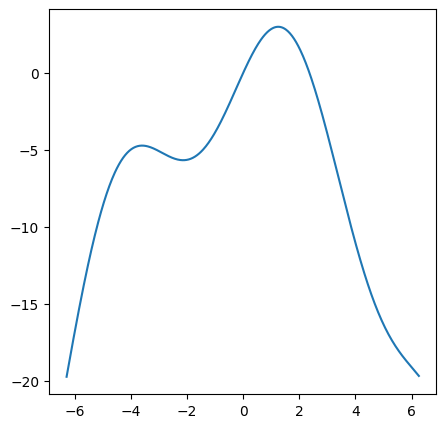

In [4]:
plt.figure(figsize=(5,5))
plt.plot(train_data[...,0], train_data[...,1])
plt.show()

In [5]:
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle=True
)

# Model declaration

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(),
            
            nn.Linear(16, 32),
            nn.ReLU(),

            nn.Linear(32, 2),
        )
    
    def forward(self, x):
        return self.model(x)

# Training

In [8]:
G = Generator()
D = Discriminator()

In [9]:
lr = 8e-5
epoch_amount = 100
loss = nn.BCELoss()
op_D = tr.optim.Adam(
    D.parameters(),
    lr=lr
)
op_G = tr.optim.Adam(
    G.parameters(),
    lr=lr
)

sch_D = tr.optim.lr_scheduler.CosineAnnealingLR(
    op_D,
    T_max = 8
)
sch_G = tr.optim.lr_scheduler.CosineAnnealingLR(
    op_G,
    T_max = 8
)

## Stages description
- stage 1,2
    Discriminator training stage
- stage 3,4
    Generator training stage
- info
    Loss function info for Discriminator (should be minimized) and Generator (should be maximized) during training



In [10]:
for ep in tqdm(range(epoch_amount)):
    for ix, (sample, _) in enumerate(train_dataloader):
        #stage 1
        sample_labels = tr.ones((batch_size, 1))
        latent_space_labels = tr.randn((batch_size, 2))
        
        G_samples = G(latent_space_labels)
        G_samples_labels = tr.zeros((batch_size, 1))
        
        all_samples = tr.cat(
            (sample, G_samples)
        )
        all_labels = tr.cat(
            (sample_labels, G_samples_labels)
        )
        
        #stage 2
        D.train()
        
        D.zero_grad()
        out_D = D(all_samples)
        loss_D = loss(out_D, all_labels)
        loss_D.backward()
        op_D.step()
        
        D.eval()
        
        #stage 3
        latent_space_samples = tr.randn((batch_size, 2))
        
        #stage 4
        G.train()
        
        G.zero_grad()
        G_samples = G(latent_space_samples)
        out_D_G = D(G_samples)
        loss_G = loss(out_D_G, sample_labels)
        loss_G.backward()
        op_G.step()
        
        G.eval()

        sch_G.step()
        sch_D.step()
    
        #info
        if ep % 5 == 0 and ix == batch_size - 1:
            print(
                "Epoch number: {}".format(ep),
                "Generator loss: {}".format(loss_G),
                "Discriminator loss: {}".format(loss_D)
            )
        

  1%|          | 1/100 [00:00<00:17,  5.73it/s]

Epoch number: 0 Generator loss: 0.6529932022094727 Discriminator loss: 0.6405336856842041


  6%|▌         | 6/100 [00:01<00:18,  5.17it/s]

Epoch number: 5 Generator loss: 0.6823387742042542 Discriminator loss: 0.4687511920928955


 11%|█         | 11/100 [00:01<00:14,  6.21it/s]

Epoch number: 10 Generator loss: 0.771215558052063 Discriminator loss: 0.40863966941833496


 16%|█▌        | 16/100 [00:02<00:13,  6.15it/s]

Epoch number: 15 Generator loss: 0.9347453713417053 Discriminator loss: 0.3101997375488281


 22%|██▏       | 22/100 [00:03<00:11,  6.98it/s]

Epoch number: 20 Generator loss: 1.2487692832946777 Discriminator loss: 0.24244515597820282


 26%|██▌       | 26/100 [00:04<00:12,  6.14it/s]

Epoch number: 25 Generator loss: 1.7327251434326172 Discriminator loss: 0.19865433871746063


 31%|███       | 31/100 [00:04<00:10,  6.81it/s]

Epoch number: 30 Generator loss: 2.228046417236328 Discriminator loss: 0.16748525202274323


 36%|███▌      | 36/100 [00:05<00:09,  7.04it/s]

Epoch number: 35 Generator loss: 2.377671241760254 Discriminator loss: 0.060029882937669754


 42%|████▏     | 42/100 [00:06<00:07,  7.30it/s]

Epoch number: 40 Generator loss: 2.6528160572052 Discriminator loss: 0.1674255132675171


 46%|████▌     | 46/100 [00:07<00:09,  5.59it/s]

Epoch number: 45 Generator loss: 2.8308324813842773 Discriminator loss: 0.19451145827770233


 51%|█████     | 51/100 [00:07<00:06,  7.18it/s]

Epoch number: 50 Generator loss: 2.8702139854431152 Discriminator loss: 0.07877276092767715


 57%|█████▋    | 57/100 [00:08<00:06,  6.51it/s]

Epoch number: 55 Generator loss: 3.0354440212249756 Discriminator loss: 0.24749650061130524


 61%|██████    | 61/100 [00:09<00:06,  5.68it/s]

Epoch number: 60 Generator loss: 2.938093900680542 Discriminator loss: 0.26467806100845337


 66%|██████▌   | 66/100 [00:10<00:04,  6.84it/s]

Epoch number: 65 Generator loss: 2.5346975326538086 Discriminator loss: 0.18298038840293884


 71%|███████   | 71/100 [00:11<00:04,  6.04it/s]

Epoch number: 70 Generator loss: 2.5872247219085693 Discriminator loss: 0.060791097581386566


 76%|███████▌  | 76/100 [00:11<00:03,  6.47it/s]

Epoch number: 75 Generator loss: 2.5527615547180176 Discriminator loss: 0.1636219620704651


 81%|████████  | 81/100 [00:12<00:02,  6.94it/s]

Epoch number: 80 Generator loss: 2.2897932529449463 Discriminator loss: 0.3876999020576477


 87%|████████▋ | 87/100 [00:13<00:02,  6.26it/s]

Epoch number: 85 Generator loss: 2.148698091506958 Discriminator loss: 0.3456282615661621


 92%|█████████▏| 92/100 [00:14<00:01,  7.25it/s]

Epoch number: 90 Generator loss: 1.9712414741516113 Discriminator loss: 0.3428477346897125


 97%|█████████▋| 97/100 [00:15<00:00,  7.40it/s]

Epoch number: 95 Generator loss: 1.7427130937576294 Discriminator loss: 0.3379248380661011


100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


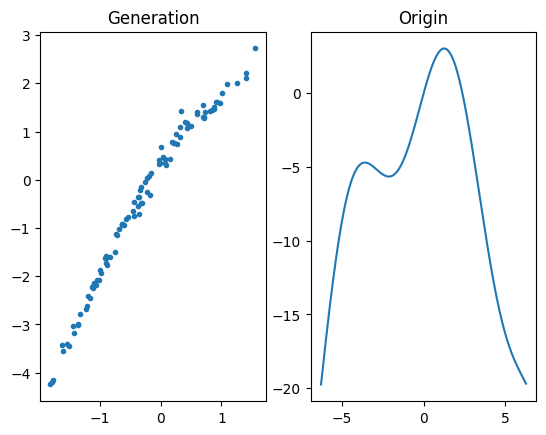

In [13]:
tr.manual_seed(666)
fig, ax = plt.subplots(1,2)

test_samples = tr.randn(100, 2)

# test_samples = tr.ones(train_data_length, 2)
# test_samples[...,0] = tr.arange(-2 * tr.pi , 2 * tr.pi, (4*tr.pi)/train_data_length)
# test_samples[...,1] = 4 * tr.sin(train_data[...,0]) - 1/2 * (train_data[...,0] ** 2)

generation = G(test_samples).detach()

ax[0].plot(generation[:, 0], generation[:, 1], ".")
ax[0].set_title("Generation")
ax[1].plot(train_data[...,0], train_data[...,1])
ax[1].set_title("Origin")
plt.show()